## Load Packages

In [1]:
from __future__ import print_function, division
import pandas as pd
#import numpy as np
import geopandas as gp
import pylab as pl
import os
import statsmodels.formula.api as smf
from pandas.tools.plotting import scatter_matrix
import matplotlib.pyplot as plt

%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Set up functions to download data

In [2]:
def Energy_CSV():
    print ("Downloading Energy_Water File")
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + "Energy_and_Water_Data_Disclosure_for_Local_Law_84__2013_.csv"):
        if os.path.isfile("Energy_and_Water_Data_Disclosure_for_Local_Law_84__2013_.csv"):
            if os.system("mv " + "Energy_and_Water_Data_Disclosure_for_Local_Law_84__2013_.csv" + os.getenv("PUIDATA")):
                print ("Error moving Energy_Water file...")
    else:
        print ("Energy_Water File is in place...")
        
def MN_Pluto_SHP():
    print ("Downloading MN PLUTO SHAPE File")
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + "MNMapPLUTO.shp"):
        if os.path.isfile("MNMapPLUTO.shp"):
            if os.system("mv " + "MNMapPLUTO.shp" + os.getenv("PUIDATA")):
                print ("Error moving MN PLUTO SHAPE file...")
    else:
        print ("MN PLUTO SHAPE File is in place...")

In [3]:
Energy_CSV()
MN_Pluto_SHP()

Energy_Water File is in place...
MN PLUTO SHAPE File is in place...


### Download Data (takes a bit of time)

In [4]:
nrg = pd.read_csv(os.getenv("PUIDATA") + "/" + 'Energy_and_Water_Data_Disclosure_for_Local_Law_84__2013_.csv')
bsize = gp.read_file(os.getenv("PUIDATA") + "/" + 'MNMapPLUTO.shp')

## Munge Building Energy data:

In [5]:
print(len(nrg))
nrg.columns

16170


Index([u'Record Number', u'NYC Borough, Block, and Lot (BBL)',
       u'Co-reported BBL Status', u'BBLs Co-reported',
       u'Reported NYC Building Identificaiton Numbers (BINs)',
       u'Street Number', u'Street Name', u'Borough', u'Zip Code',
       u'DOF Benchmarking Submission Status', u'Site EUI(kBtu/ft2)',
       u'Weather Normalized Site EUI(kBtu/ft2)', u'Source EUI(kBtu/ft2)',
       u'Weather Normalized Source EUI(kBtu/ft2)',
       u'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)',
       u'Automatic Water Benchmarking Eligible', u'Reported Water Method',
       u'ENERGY STAR Score', u'Total GHG Emissions(MtCO2e)',
       u'Direct GHG Emissions(MtCO2e)', u'Indirect GHG Emissions(MtCO2e)',
       u'Reported Property Floor Area (Building(s)) (ft²)',
       u'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       u'Primary Property Type - Self Selected', u'DOF Number of Buildings'],
      dtype='object')

In [6]:
nrg.drop(['Record Number',
          'Co-reported BBL Status', 'BBLs Co-reported', 'Reported NYC Building Identificaiton Numbers (BINs)',
          'Street Number', 'Street Name', 'Borough', 'Zip Code',
          'DOF Benchmarking Submission Status',
          'Weather Normalized Site EUI(kBtu/ft2)', 'Source EUI(kBtu/ft2)', 'Weather Normalized Source EUI(kBtu/ft2)',
          'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)',
          'Automatic Water Benchmarking Eligible', 'Reported Water Method',
          'ENERGY STAR Score',
          'Total GHG Emissions(MtCO2e)', 'Direct GHG Emissions(MtCO2e)', 'Indirect GHG Emissions(MtCO2e)',
          'DOF Property Floor Area (Buildngs and Parking)(ft2)',
          'Primary Property Type - Self Selected','DOF Number of Buildings']
         ,axis=1,inplace=True)


print(len(nrg),nrg.columns)
nrg.head(2)

# KEEP:
#   'NYC Borough, Block, and Lot (BBL)'
#   'Reported Property Floor Area (Building(s)) (ft²)'
#   'Site EUI(kBtu/ft2)'

16170 Index([u'NYC Borough, Block, and Lot (BBL)', u'Site EUI(kBtu/ft2)',
       u'Reported Property Floor Area (Building(s)) (ft²)'],
      dtype='object')


,"NYC Borough, Block, and Lot (BBL)",Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²)
0,1.000410e+09,NaN,918919
1,4.021460e+09,NaN,NaN


#### rename BBL column name to key on PLUTO index (and shorten other column names):

In [7]:
nrg.rename(columns={'NYC Borough, Block, and Lot (BBL)' : 'BBL'}, inplace=True)
nrg.rename(columns={'Reported Property Floor Area (Building(s)) (ft²)' :'Propsf'}, inplace=True)
nrg.rename(columns={'Site EUI(kBtu/ft2)' :'energypsf'}, inplace=True)

#### remedy datatype, data structure and aphanumeric encoding issues:

In [8]:
def canconvert(mydata):
    try :
        float(mydata)
        return True
    except ValueError:
        return False

In [9]:
indx = (np.vectorize(canconvert)(nrg['BBL']))
print ("invalid entries changed to NaN %d"%sum(indx))
nrg['BBL'][~indx] = float('NaN')

indx = (np.vectorize(canconvert)(nrg['energypsf']))
print ("invalid entries changed to NaN %d"%sum(indx))
nrg['energypsf'][~indx] = float('NaN')

indx = (np.vectorize(canconvert)(nrg['Propsf']))
print ("invalid entries changed to NaN %d"%sum(indx))
nrg['Propsf'][~indx] = float('NaN')


invalid entries changed to NaN 16170
invalid entries changed to NaN 15513
invalid entries changed to NaN 15430


/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [10]:
nrg.dropna(inplace=True)

In [11]:
print(len(nrg))
nrg.head(2)

11457


,BBL,energypsf,Propsf
16,1.013110e+09,125.4,330000
30,2.022150e+09,6224.5,342048


## Munge PLUTO data:

In [12]:
print(len(bsize))
bsize.columns

42697


Index([    u'APPBBL',    u'APPDate',    u'Address', u'AllZoning1',
       u'AllZoning2', u'AreaSource', u'AssessLand',  u'AssessTot',
              u'BBL',   u'BldgArea',  u'BldgClass',  u'BldgDepth',
        u'BldgFront',      u'Block',   u'BoroCode',    u'Borough',
         u'BsmtCode',  u'BuiltCode',   u'BuiltFAR',     u'CB2010',
               u'CD',     u'CT2010',    u'ComArea',    u'CommFAR',
          u'CondoNo',    u'Council',  u'EDesigNum',  u'Easements',
       u'ExemptLand',  u'ExemptTot',        u'Ext',   u'FacilFAR',
       u'FactryArea',   u'FireComp', u'GarageArea', u'HealthArea',
         u'HistDist', u'IrrLotCode',    u'LandUse',   u'Landmark',
              u'Lot',    u'LotArea',   u'LotDepth',   u'LotFront',
          u'LotType',  u'LtdHeight', u'MAPPLUTO_F',   u'NumBldgs',
        u'NumFloors', u'OfficeArea',  u'OtherArea',   u'Overlay1',
         u'Overlay2',  u'OwnerName',  u'OwnerType', u'PLUTOMapID',
       u'PolicePrct',   u'ProxCode',    u'ResArea',   u'ResidF

In [13]:
bsize.drop(['APPBBL', 'APPDate',
            'Address', 'AllZoning1', 'AllZoning2', 'AreaSource',
            'AssessLand', 'AssessTot',
            'BldgArea',  'BldgClass',  'BldgDepth', 'BldgFront',
            'Block', 'BoroCode', 'Borough', 'BsmtCode', 'BuiltCode',
            'BuiltFAR',
            'CB2010', 'CD', 'CT2010',
            'ComArea', 'CommFAR',
            'CondoNo',
            'Council', 'EDesigNum', 'Easements', 'ExemptLand', 'ExemptTot', 'Ext',
            'FacilFAR', 'FactryArea', 'FireComp', 'GarageArea',
            'HealthArea',
            'HistDist', 'IrrLotCode',
            'LandUse', 'Landmark', 'Lot',
            'LotArea', 'LotDepth', 'LotFront', 'LotType', 'LtdHeight', 'MAPPLUTO_F',
            'NumBldgs', 'NumFloors',
            'OfficeArea', 'OtherArea',
            'Overlay1', 'Overlay2',
            'OwnerName',  u'OwnerType',
            'PLUTOMapID',
            'PolicePrct',
            'ProxCode',
            'ResArea', 'ResidFAR',
            'RetailArea',
            'SHAPE_Area', 'SHAPE_Leng', 'SPDist1', 'SPDist2',
            'Sanborn', 'SanitBoro', 'SanitDist', 'SanitSub',
            'SchoolDist', 'SplitZone', 'StrgeArea',
            'TaxMap', 'Tract2010',
            'UnitsRes',
            'Version', 'XCoord', 'YCoord',
            'YearAlter1', 'YearAlter2', 'YearBuilt',
            'ZMCode', 'ZipCode',
            'ZoneDist1',  u'ZoneDist2',  u'ZoneDist3',  u'ZoneDist4', 'ZoneMap',
            'geometry'],
           axis=1,inplace=True)

print(len(bsize), bsize.columns)
bsize.head(2)

# KEEP:
# 'BBL'
# 'UnitsTotal'

42697 Index([u'BBL', u'UnitsTotal'], dtype='object')


,BBL,UnitsTotal
0,1.015450e+09,18
1,1.007238e+09,50


In [14]:
indx = (np.vectorize(canconvert)(bsize.BBL))
print ("invalid entries changed to NaN %d"%sum(indx))
bsize.BBL[~indx] = float('NaN')

indx = (np.vectorize(canconvert)(bsize.UnitsTotal))
print ("invalid entries changed to NaN %d"%sum(indx))
bsize.UnitsTotal[~indx] = float('NaN')

invalid entries changed to NaN 42697
invalid entries changed to NaN 42697


/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [15]:
bsize.dropna(inplace=True)

In [16]:
print(len(bsize))
bsize.columns

42697


Index([u'BBL', u'UnitsTotal'], dtype='object')

### making sure we got numerical values which I can do some math with:

In [17]:
nrg['BBL'] = nrg['BBL'].astype(float)
nrg['Propsf'] = nrg['Propsf'].astype(float)
nrg['energypsf'] = nrg['energypsf'].astype(float)
bsize.BBL = bsize.BBL.astype(float)
bsize.UnitsTotal = bsize.UnitsTotal.astype(float)

print(nrg.head(5))
print(bsize.head(5))

             BBL  energypsf    Propsf
16  1.013110e+09      125.4  330000.0
30  2.022150e+09     6224.5  342048.0
44  1.010140e+09      154.9  841709.0
45  4.002520e+09       46.0  390400.0
56  4.004370e+09       66.2  528060.0
            BBL  UnitsTotal
0  1.015450e+09        18.0
1  1.007238e+09        50.0
2  1.016800e+09        10.0
3  1.013850e+09        32.0
4  1.011970e+09        26.0


### Merge Tables

In [18]:
bblnrg = pd.merge(nrg,bsize,on='BBL',how='inner')

In [19]:
print(type(bblnrg['BBL'][16]))
print(type(bblnrg['Propsf'][16]))
print(type(bblnrg['energypsf'][16]))
print(type(bblnrg['UnitsTotal'][16]))

<type 'numpy.float64'>
<type 'numpy.float64'>
<type 'numpy.float64'>
<type 'numpy.float64'>


####  - placing resonable max/min boundaries on data
####  - adding & transforming relevant variables

In [20]:
#Bounding variables to reasonable limits and assigning exra colunmns with log values of relevant data 

bblnrg = bblnrg[bblnrg['BBL']>0.00000001]
bblnrg = bblnrg[bblnrg['BBL']<99999999999]
bblnrg = bblnrg[bblnrg['Propsf']>1]
bblnrg = bblnrg[bblnrg['Propsf']<9999999]
bblnrg = bblnrg[bblnrg['energypsf']>.05]
bblnrg = bblnrg[bblnrg['energypsf']<2800000]
bblnrg = bblnrg[bblnrg['UnitsTotal']>1]
bblnrg = bblnrg[bblnrg['UnitsTotal']<2000]

bblnrg['totenergy'] = bblnrg['energypsf']*bblnrg['Propsf']

bblnrg['log_units'] = log(bblnrg['UnitsTotal'])
bblnrg['log_energy'] = log(bblnrg['totenergy'])
bblnrg['log_energypsf'] = log(bblnrg['energypsf'])

bblnrg = bblnrg[bblnrg['log_units']>.000001]
bblnrg = bblnrg[bblnrg['log_units']<999999999]
bblnrg = bblnrg[bblnrg['log_energy']>.00001]
bblnrg = bblnrg[bblnrg['log_energy']<99999999]
bblnrg = bblnrg[bblnrg['log_energypsf']>.00001]
bblnrg = bblnrg[bblnrg['log_energypsf']<99999999]

bblnrg.head(3)

,BBL,energypsf,Propsf,UnitsTotal,totenergy,log_units,log_energy,log_energypsf
0,1.013110e+09,125.4,330000.0,56.0,41382000.0,4.025352,17.538357,4.831509
1,1.010140e+09,154.9,841709.0,2.0,130380724.1,0.693147,18.685969,5.042780
2,1.007660e+09,122.3,59468.0,8.0,7272936.4,2.079442,15.799671,4.806477


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe9c690f8d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fe9e7740290>]], dtype=object)

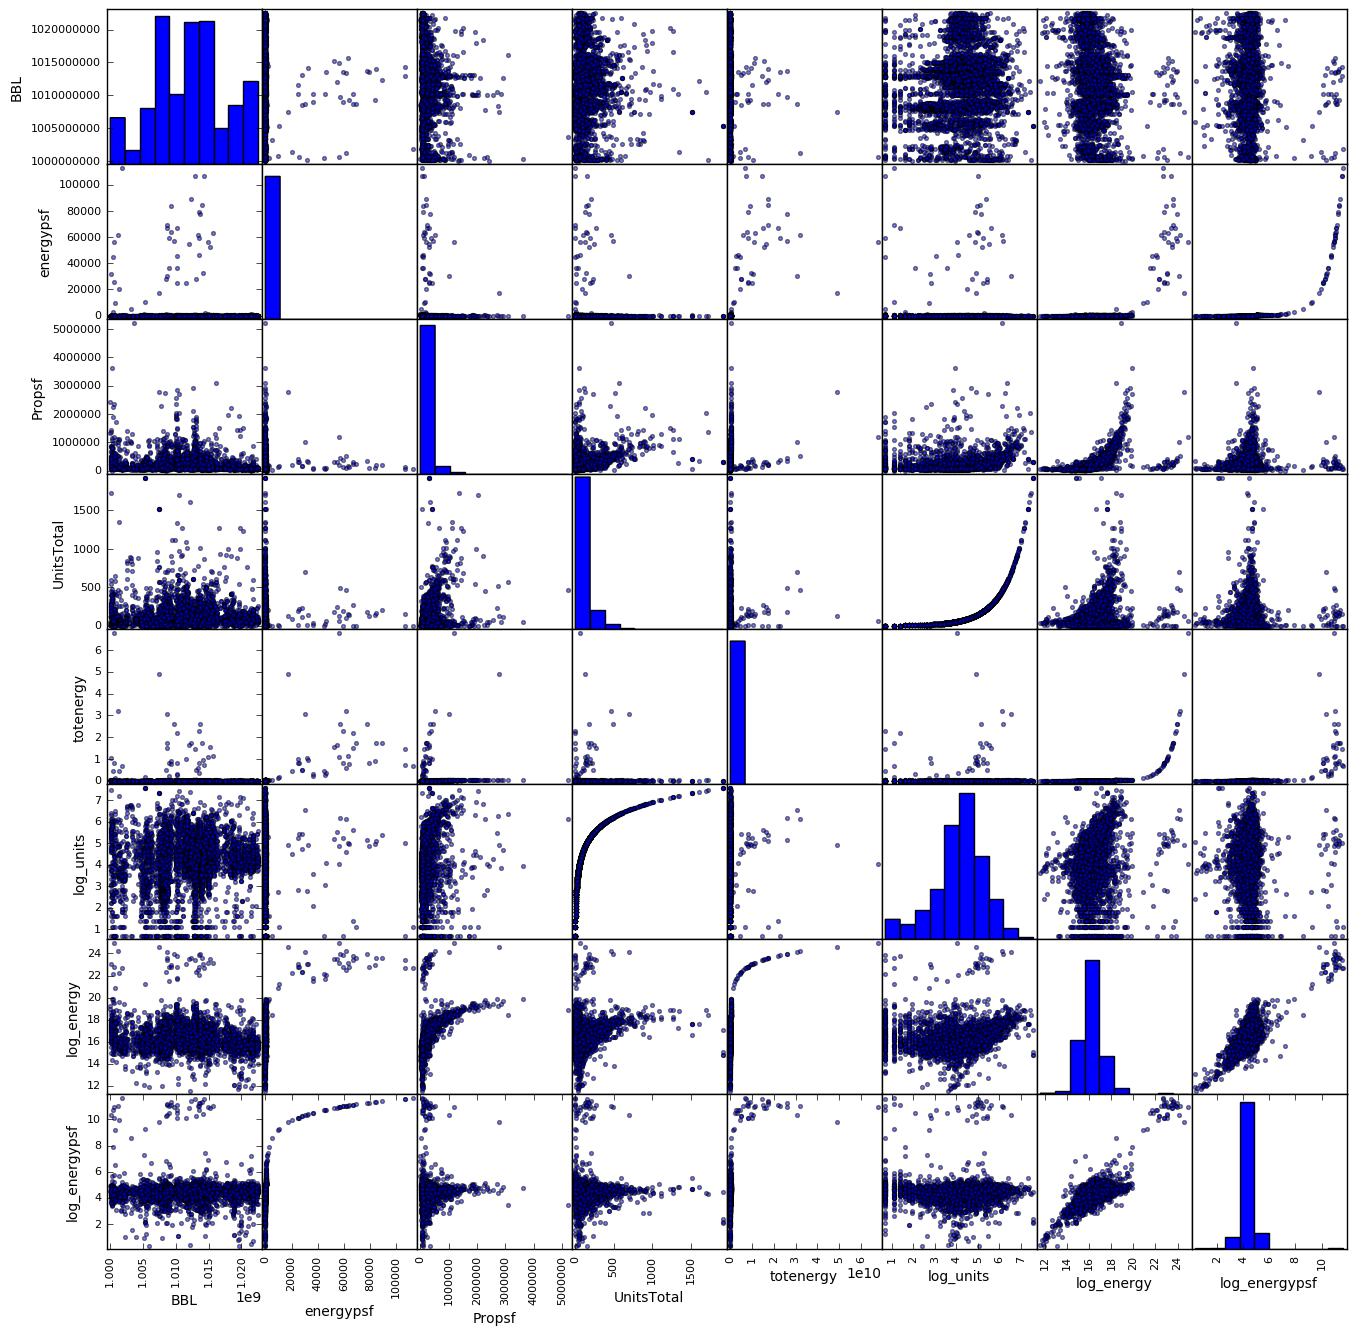

In [21]:
scatter_matrix (bblnrg, s=30, figsize=(16, 16))

##### above, there seems to be some relationships, but can't say for sure.  Let's take a closer look...

## Exploring & Modeling

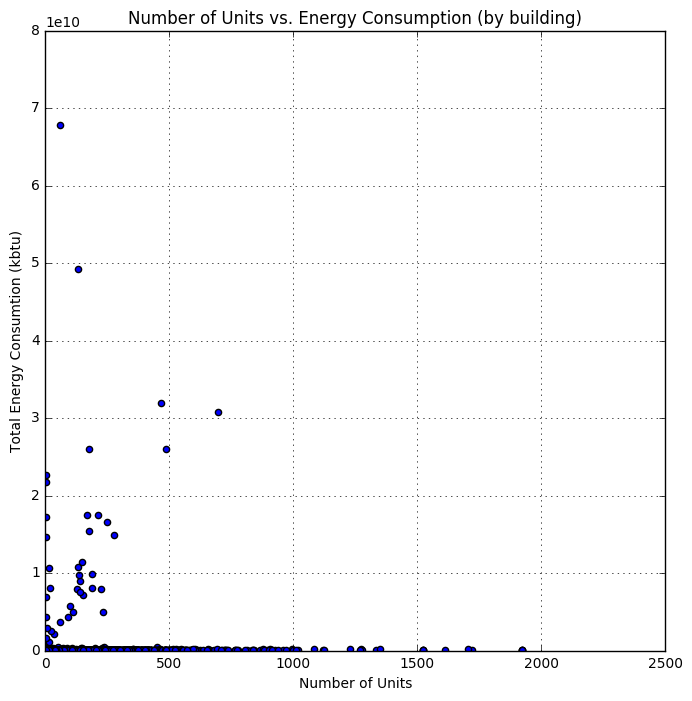

In [22]:
x = bblnrg['UnitsTotal']
y = bblnrg['totenergy']

pl.figure(figsize=(8,8))
pl.scatter(x,y,)
#figsize=(10, 10)
pl.xlabel('Number of Units')
pl.ylabel('Total Energy Consumtion (kbtu)')
pl.title('Number of Units vs. Energy Consumption (by building)')
pl.xlim(xmin=0)
pl.ylim(ymin=0)
pl.grid(True)
pl.show()

#### Looks a bit logorithmic (above).  Let's look...

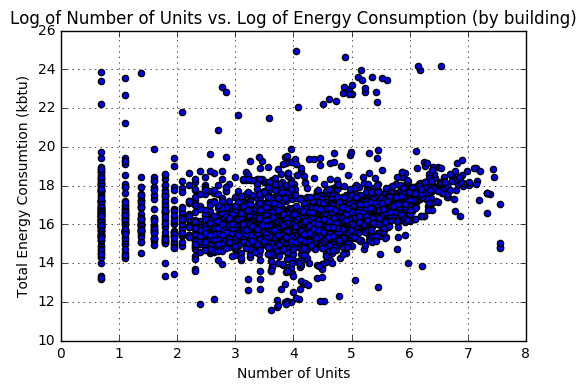

In [23]:
x = bblnrg['log_units']
y = bblnrg['log_energy']
#pl.figure(figsize=(10,7))
pl.scatter(x,y)
#figsize=(25, 16)
pl.xlabel('Number of Units')
pl.ylabel('Total Energy Consumtion (kbtu)')
pl.title('Log of Number of Units vs. Log of Energy Consumption (by building)')
#pl.xlim(xmax=12)
#pl.ylim(ymin=10)
pl.grid(True)
pl.show()

#### We may need to cut away some data

In [24]:
bblnrg = bblnrg[bblnrg['log_energy']>12]
bblnrg = bblnrg[bblnrg['log_energy']<22]

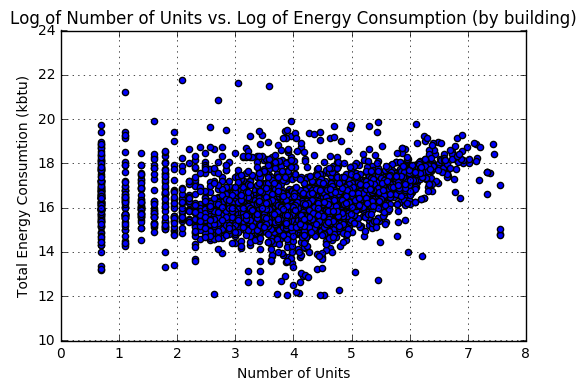

In [25]:
x = bblnrg['log_units']
y = bblnrg['log_energy']
#pl.figure(figsize=(10,7))
pl.scatter(x,y)
#figsize=(25, 16)
pl.xlabel('Number of Units')
pl.ylabel('Total Energy Consumtion (kbtu)')
pl.title('Log of Number of Units vs. Log of Energy Consumption (by building)')
#pl.xlim(xmin=12)
#pl.ylim(ymin=12)
#pl.ylim(ymax=22)
pl.grid(True)
pl.show()

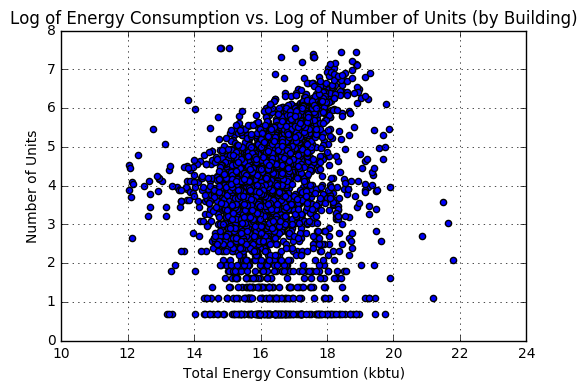

In [26]:
y = bblnrg['log_units']
x = bblnrg['log_energy']
#pl.figure(figsize=(8,8))
pl.scatter(x,y)
pl.ylabel('Number of Units')
pl.xlabel('Total Energy Consumtion (kbtu)')
#plt.xlim(xmin=0)
#plt.ylim(ymin=0)
pl.title('Log of Energy Consumption vs. Log of Number of Units (by Building)')
pl.grid(True)
pl.show()

### Fitting 

In [27]:
linear_e = smf.ols(formula='log_energy ~ log_units', data=bblnrg).fit()
print("intercept: ", linear_e.params['Intercept'], "b: ", linear_e.params['log_units'])
linear_e.summary()

intercept:  15.3525180573 b:  0.201433823079


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_energy   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     320.5
Date:                Thu, 20 Oct 2016   Prob (F-statistic):           2.36e-69
Time:                        13:33:32   Log-Likelihood:                -6219.4
No. Observations:                4608   AIC:                         1.244e+04
Df Residuals:                    4606   BIC:                         1.246e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     15.3525      0.048    317.868      0.000        15.258    15.447
log_units      0.2014      0.011     17.904      0.000         0.179     0.223
==============================================================================
Omnibus:                      749.385   Durbin-Watson:                   1.535
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2917.659
Skew:                           0.767   Prob(JB):                         0.00
Kurtosis:                       6.584   Cond. No.                         15.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

chsq: 243.13072102


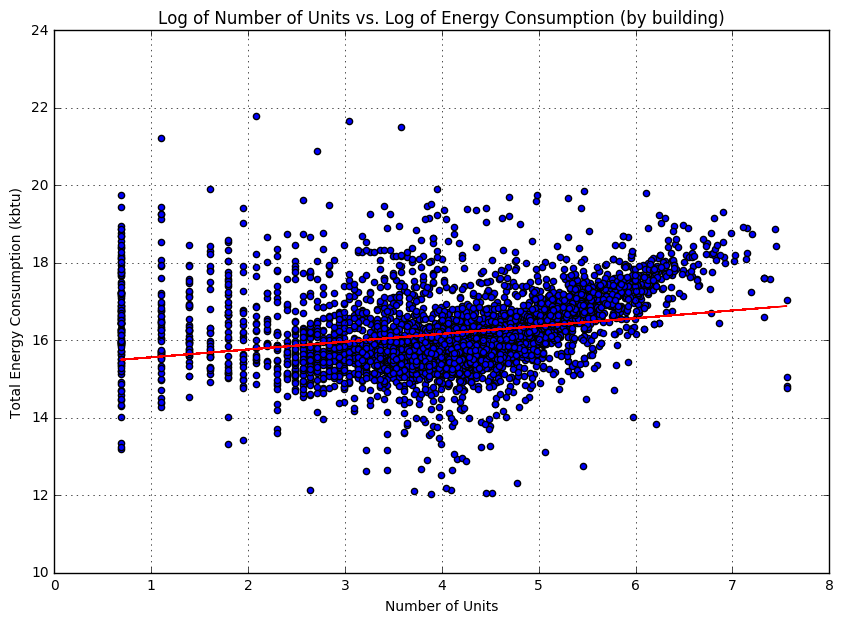

In [28]:
energy = bblnrg['log_energy']
units = bblnrg['log_units']

m_linear_e = linear_e.params['Intercept']
b_linear_e = linear_e.params['log_units']

chsq_e = (((energy-(m_linear_e + b_linear_e * units))**2)/energy).sum()

pl.figure(figsize=(10,7))

pl.plot(units, m_linear_e + b_linear_e * units , color='red')
pl.scatter(units, energy)

plt.xlim(xmin=0)
#plt.ylim(ymin=0)

pl.title('Log of Number of Units vs. Log of Energy Consumption (by building)')
pl.ylabel("Total Energy Consumption (kbtu)")
pl.xlabel("Number of Units")
pl.grid(True)

print("chsq:", chsq_e)

In [29]:
linear_u = smf.ols(formula='log_units ~ log_energy', data=bblnrg).fit()
print("intercept: ", linear_u.params['Intercept'], "b: ", linear_u.params['log_energy'])
linear_u.summary()

intercept:  -1.11143832863 b:  0.323001161414


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_units   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     320.5
Date:                Thu, 20 Oct 2016   Prob (F-statistic):           2.36e-69
Time:                        13:33:41   Log-Likelihood:                -7307.3
No. Observations:                4608   AIC:                         1.462e+04
Df Residuals:                    4606   BIC:                         1.463e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -1.1114      0.292     -3.800      0.000        -1.685    -0.538
log_energy     0.3230      0.018     17.904      0.000         0.288     0.358
==============================================================================
Omnibus:                      826.288   Durbin-Watson:                   1.441
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1486.778
Skew:                          -1.132   Prob(JB):                         0.00
Kurtosis:                       4.617   Cond. No.                         273.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

chsq: 4146.17609401


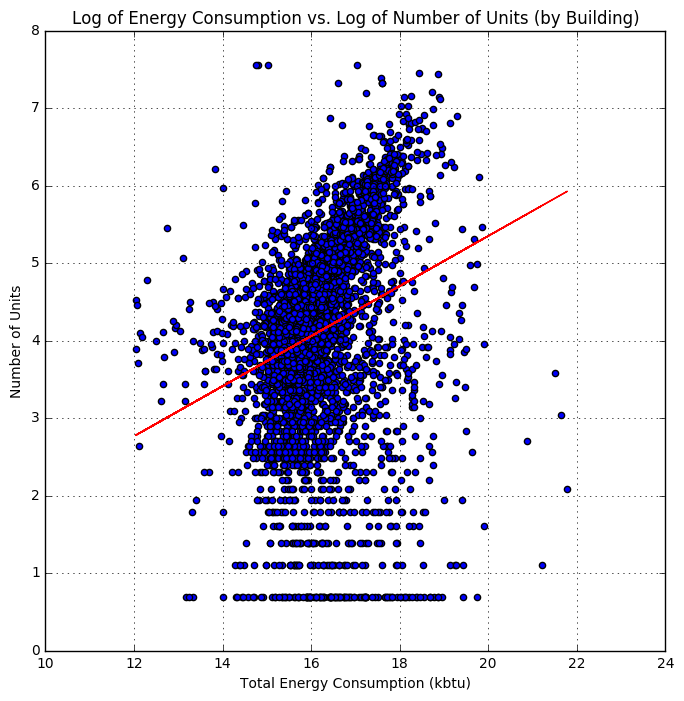

In [30]:
units = bblnrg['log_units']
energy = bblnrg['log_energy']


m_linear_u = linear_u.params['Intercept']
b_linear_u = linear_u.params['log_energy']

chsq = (((units-(m_linear_u + b_linear_u * energy))**2)/units).sum()

pl.figure(figsize=(8,8))

pl.plot(energy, m_linear_u + b_linear_u * energy, color='red')
pl.scatter(energy, units)

plt.ylim(ymin=0)
pl.title('Log of Energy Consumption vs. Log of Number of Units (by Building)')
pl.xlabel("Total Energy Consumption (kbtu)")
pl.ylabel("Number of Units")
pl.grid(True)

print("chsq:", chsq)

### let's try polynomials

In [31]:
bblnrg.head(3)

,BBL,energypsf,Propsf,UnitsTotal,totenergy,log_units,log_energy,log_energypsf
0,1.013110e+09,125.4,330000.0,56.0,41382000.0,4.025352,17.538357,4.831509
1,1.010140e+09,154.9,841709.0,2.0,130380724.1,0.693147,18.685969,5.042780
2,1.007660e+09,122.3,59468.0,8.0,7272936.4,2.079442,15.799671,4.806477


In [32]:
bblnrg['units_sq'] = bblnrg['UnitsTotal']**2
bblnrg['energy_sq'] = bblnrg['totenergy']**2

bblnrg['log_units_sq'] = log(bblnrg['units_sq'])
bblnrg['log_energy_sq'] = log(bblnrg['energy_sq'])

#bblnrg['log_units_sq'] = (log(bblnrg['UnitsTotal']))**2
#bblnrg['log_energy_sq'] = (log(bblnrg['totenergy']))**2

In [33]:
bblnrg.head(3)

,BBL,energypsf,Propsf,UnitsTotal,totenergy,log_units,log_energy,log_energypsf,units_sq,energy_sq,log_units_sq,log_energy_sq
0,1.013110e+09,125.4,330000.0,56.0,41382000.0,4.025352,17.538357,4.831509,3136.0,1.712470e+15,8.050703,35.076713
1,1.010140e+09,154.9,841709.0,2.0,130380724.1,0.693147,18.685969,5.042780,4.0,1.699913e+16,1.386294,37.371939
2,1.007660e+09,122.3,59468.0,8.0,7272936.4,2.079442,15.799671,4.806477,64.0,5.289560e+13,4.158883,31.599341


In [34]:
poly = smf.ols(formula='log_energy ~ log_units + log_units_sq', data=bblnrg).fit()
print("intercept:", poly.params['Intercept'], "b:", poly.params['log_units'], "b2:", poly.params['log_units_sq'])
poly.summary()

intercept: 15.3525180573 b: 0.0402867646157 b2: 0.0805735292314


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_energy   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     320.5
Date:                Thu, 20 Oct 2016   Prob (F-statistic):           2.36e-69
Time:                        13:33:57   Log-Likelihood:                -6219.4
No. Observations:                4608   AIC:                         1.244e+04
Df Residuals:                    4606   BIC:                         1.246e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept       15.3525      0.048    317.868      0.000        15.258    15.447
log_units        0.0403      0.002     17.904      0.000         0.036     0.045
log_units_sq     0.0806      0.005     17.904      0.000         0.072     0.089
==============================================================================
Omnibus:                      749.385   Durbin-Watson:                   1.535
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2917.659
Skew:                           0.767   Prob(JB):                         0.00
Kurtosis:                       6.584   Cond. No.                     2.64e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.15e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

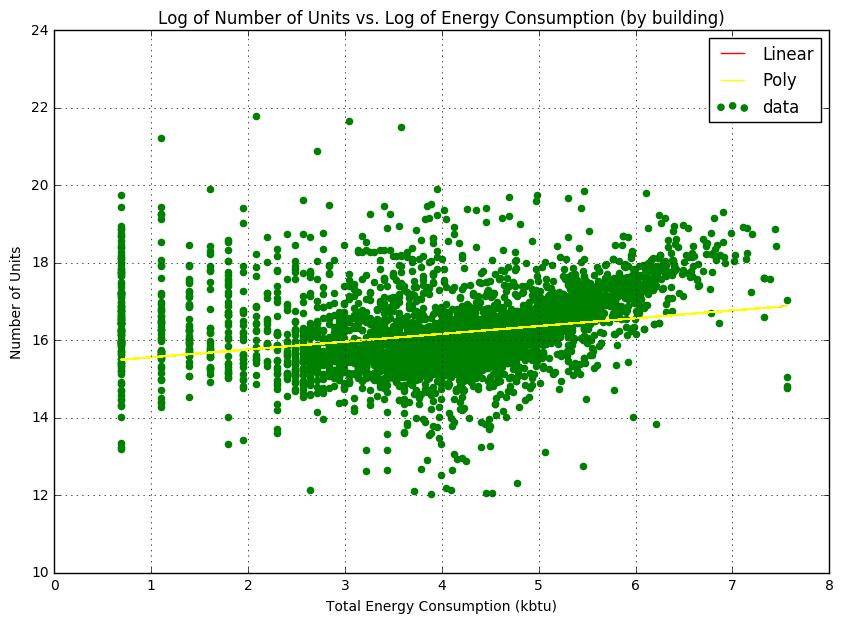

In [35]:
energy = bblnrg['log_energy']
units = bblnrg['log_units']
units_sq = bblnrg['log_units_sq']

m_poly = poly.params['Intercept']
b_poly = poly.params['log_units']
b2_poly = poly.params['log_units_sq']


pl.figure(figsize=(10,7))

pl.plot(units, m_linear_e + b_linear_e * units, color='red', label='Linear')
pl.plot(units, m_poly + b_poly * units + b2_poly * units_sq, color='yellow', label='Poly')
pl.scatter(units, energy, color = 'green', label='data')

#plt.ylim(ymin=0)
pl.title('Log of Number of Units vs. Log of Energy Consumption (by building)')
pl.xlabel("Total Energy Consumption (kbtu)")
pl.ylabel("Number of Units")
pl.legend()
pl.grid(True)

In [36]:
print ("Log Likelihood for linear:", linear_e.llf)
print ("Log Likelihood for poly:", poly.llf)
print ("LR : ", -2 * (-linear_e.llf - (-poly.llf)))
print ("LR from statsmodels:", poly.compare_lr_test(linear_e))

Log Likelihood for linear: -6219.38934838
Log Likelihood for poly: -6219.38934838
LR :  -0.0
LR from statsmodels: (-0.0, nan, 0.0)


##### Notice that the LR is zero/undefined since the models are equivalent.  To be continued... 